SMOTE
Implement weights for Tree based algo
Tune XGBoost


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
import scipy.stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
#How many records and how many features we have ?
df.shape

(7043, 21)

In [4]:
#Is the data balanced ? Answer is no, only 26.6 % of the records are of churning customers.
df["Churn"].value_counts(normalize = True)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

In [5]:
#Do we have any null values ? Answer is No 
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
#Do we have multiple records of same customer ? - answer is no
df.duplicated("customerID").sum()

0

In some datasets (especially for regression problems) having multiple records of same user can help us in using the user ID by transorming it to the mean/median of responsposne variable (Responde or Target Coding). Here it is not the case so CustomerID is not an useful feature.

In [7]:
df["gender"].value_counts(normalize = True)

Male      0.504756
Female    0.495244
Name: gender, dtype: float64

Data has even distribution of Male and Females

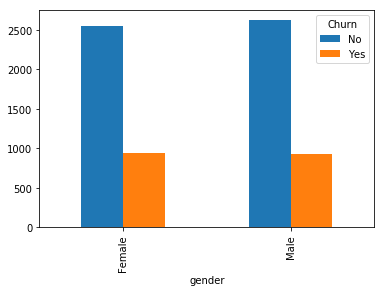

In [8]:
pd.crosstab(df["gender"],df["Churn"]).plot(kind='bar')

Gender does not seem to be an important feature, Churn percentage is almost the same in Males and Females

In [9]:
#Does not having a partner mean no depednents ?- answer is no but it is less likely to have dependents. 
#There can be dependents other than partner
cont = pd.crosstab(df["Partner"],df["Dependents"])
print(cont)
scipy.stats.chi2_contingency(cont)

Dependents    No   Yes
Partner               
No          3280   361
Yes         1653  1749


(1441.2452212367994, 0.0, 1, array([[2550.19920488, 1090.80079512],
        [2382.80079512, 1019.19920488]]))

Churn         No   Yes
Dependents            
No          3390  1543
Yes         1784   326


(189.12924940423474,
 4.9249216612154196e-43,
 1,
 array([[3623.93042737, 1309.06957263],
        [1550.06957263,  559.93042737]]))

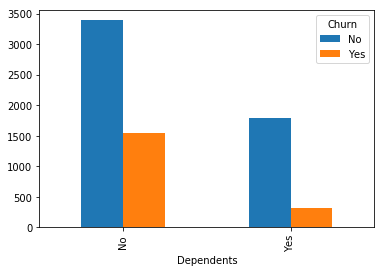

In [124]:
#How important is the Dependents featur ?
cont = pd.crosstab(df["Dependents"], df["Churn"])
print(cont)
pd.crosstab(df["Dependents"], df["Churn"]).plot(kind="bar")
scipy.stats.chi2_contingency(cont)

Dependent seems to be imortant feature, customers with no dependents tend to churn more (around 31%)

Churn      No   Yes
Partner            
No       2441  1200
Yes      2733   669


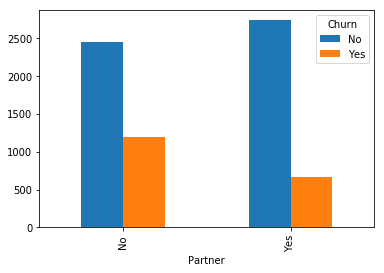

In [10]:
#How important is the Partner featur ?
print(pd.crosstab(df["Partner"], df["Churn"]))
pd.crosstab(df["Partner"], df["Churn"]).plot(kind="bar")

Partner feature is somewhat impoprtant, customers with no partner has slightly higher tendency to churn

In [11]:
#How many senior citizens we have ?
df["SeniorCitizen"].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Churn            No   Yes
SeniorCitizen            
0              4508  1393
1               666   476


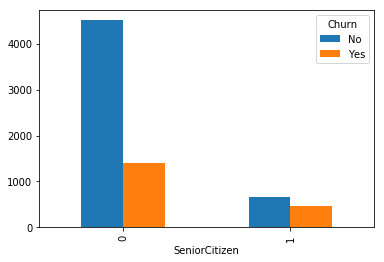

In [12]:
#How much churn is there in Senior Citizens ?
print(pd.crosstab(df["SeniorCitizen"], df["Churn"]))
pd.crosstab(df["SeniorCitizen"], df["Churn"]).plot(kind="bar")

This seems to be important parameter. Above results show that Senior citizen tend to churn more than non senior citizen. The percentage of churning in Senior citizen is around 40 % and in non senior citizen it is around 24 %

In [13]:
#How is the tenure looking like? - highly dispersed, need to find out why min is zero, is that a bad data or a new customer
df["tenure"].describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [14]:
#How many customers are having tenure = 0? answer is 11
df[df["tenure"] ==0].count()

customerID          11
gender              11
SeniorCitizen       11
Partner             11
Dependents          11
tenure              11
PhoneService        11
MultipleLines       11
InternetService     11
OnlineSecurity      11
OnlineBackup        11
DeviceProtection    11
TechSupport         11
StreamingTV         11
StreamingMovies     11
Contract            11
PaperlessBilling    11
PaymentMethod       11
MonthlyCharges      11
TotalCharges        11
Churn               11
dtype: int64

In [15]:
def univariatePlot(feature):
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    g1=sns.FacetGrid(df, hue="Churn", size=5) \
       .map(sns.distplot, feature, hist=False, kde=True,ax=ax1) \
       .add_legend();

    sns.boxplot('Churn',feature,hue='Churn', data=df,ax=ax2)

    plt.close(g1.fig)
    plt.show()

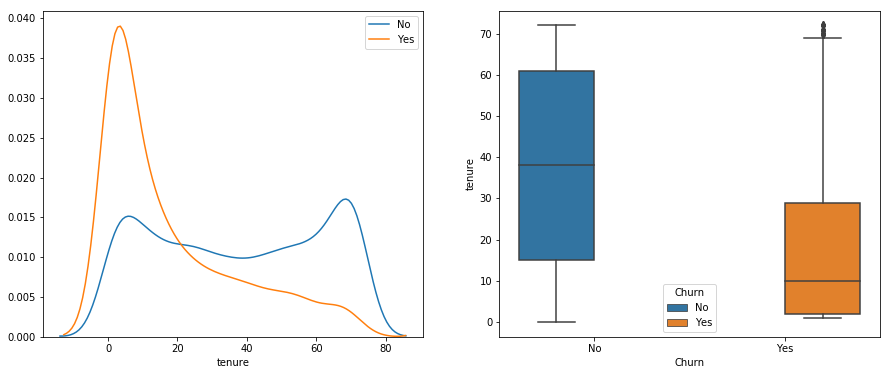

In [16]:
#How is the distribution of tenure ?
univariatePlot("tenure")

Tenure seems to be very important feature in predicting Churn. PDF shows that customers with tenure less than 20 months have high probability of leaving. As the tenure increases, the probability of churn goes down.
Box plot shows that there is some overlap on the basis of tenure but there are very few customers having tenure more than 25-30 months leaving the telco

Churn           No   Yes
PhoneService            
No             512   170
Yes           4662  1699


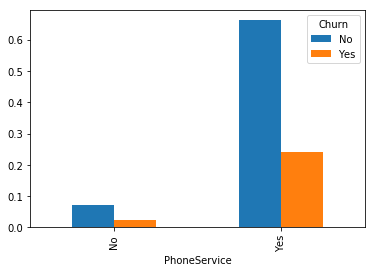

In [17]:
print(pd.crosstab(df["PhoneService"], df["Churn"]))
pd.crosstab(df["PhoneService"],df["Churn"],normalize = True).plot(kind = "bar")

Phone Service does not seem to be very important feature the proportion of churning customer is almost the same (24-26%) in customers with Phone Service and without Phone Service.

Churn               No  Yes
MultipleLines              
No                2541  849
No phone service   512  170
Yes               2121  850


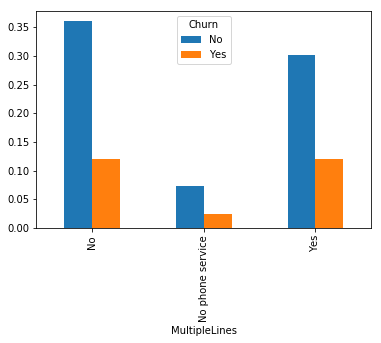

In [18]:
print(pd.crosstab(df["MultipleLines"], df["Churn"]))
pd.crosstab(df["MultipleLines"],df["Churn"],normalize = True).plot(kind = "bar")

MultipleLines does not seem to be very decisive feature from above results

Churn              No   Yes
InternetService            
DSL              1962   459
Fiber optic      1799  1297
No               1413   113


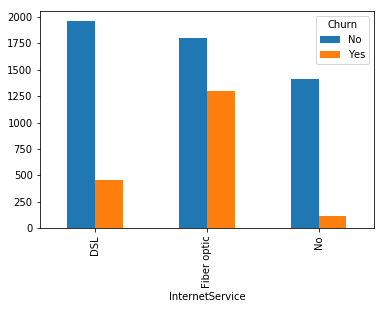

In [19]:
print(pd.crosstab(df["InternetService"], df["Churn"]))
pd.crosstab(df["InternetService"],df["Churn"]).plot(kind = "bar")

This seems to be very impoortant feature, customers with Fiber Optic service have higher churn. Maybe Finber Optic service 
is not as good as DSL 

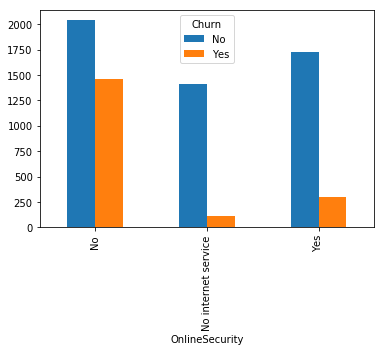

In [20]:
 pd.crosstab(df["OnlineSecurity"],df["Churn"]).plot(kind = "bar")

In [21]:
 pd.crosstab(df["OnlineSecurity"],df["Churn"])

Churn,No,Yes
OnlineSecurity,,
No,2037,1461
No internet service,1413,113
Yes,1724,295


This is important observation, customers who have not opted for online security tend to churn more. The proportion of Churned customers is over 40% for customers who have not opted for oneline security. This makes OnelineSecurity an important feature for the classification model.

Churn                  No   Yes
DeviceProtection               
No                   1884  1211
No internet service  1413   113
Yes                  1877   545


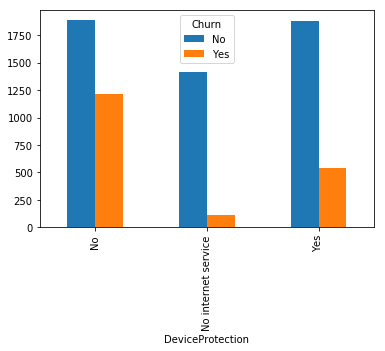

In [22]:
pd.crosstab(df["DeviceProtection"],df["Churn"]).plot(kind = "bar")
print(pd.crosstab(df["DeviceProtection"],df["Churn"]))

Device Protection feature is also a good indicator because because alsmost 40% of the customers not opted for Device Protection have churned.

Churn                  No   Yes
TechSupport                    
No                   2027  1446
No internet service  1413   113
Yes                  1734   310


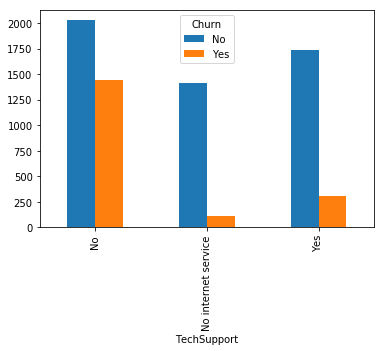

In [24]:
pd.crosstab(df["TechSupport"],df["Churn"]).plot(kind = "bar")
print(pd.crosstab(df["TechSupport"],df["Churn"]))

Same story repeats for TechSupport. More sticky customers opt for customer support

Churn                  No  Yes
StreamingTV                   
No                   1868  942
No internet service  1413  113
Yes                  1893  814


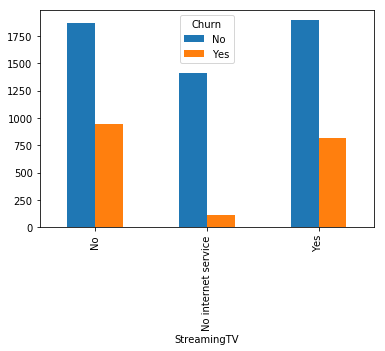

In [23]:
pd.crosstab(df["StreamingTV"],df["Churn"]).plot(kind = "bar")
print(pd.crosstab(df["StreamingTV"],df["Churn"]))

Streaming TV is not as strong indicator as previous two. Nearly 33% of customers not opted for Streaming TV have churned which is higher than the overal proportion of 26.5%. However customers who opted for Streaming TV have also demonstrated similar churning behavior (around 30%)

Churn                  No  Yes
StreamingMovies               
No                   1847  938
No internet service  1413  113
Yes                  1914  818


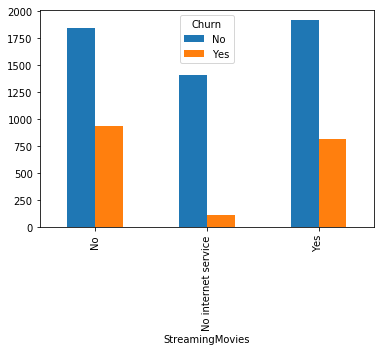

In [24]:
pd.crosstab(df["StreamingMovies"],df["Churn"]).plot(kind = "bar")
print(pd.crosstab(df["StreamingMovies"],df["Churn"]))

Churn                  No   Yes
OnlineBackup                   
No                   1855  1233
No internet service  1413   113
Yes                  1906   523


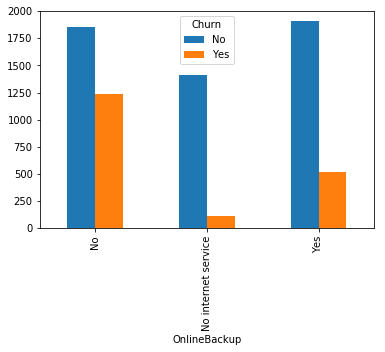

In [25]:
pd.crosstab(df["OnlineBackup"],df["Churn"]).plot(kind = "bar")
print(pd.crosstab(df["OnlineBackup"],df["Churn"]))

OnlineBackup seems to be important indicator, customers opted for OnlineBackup are less likely to churn

Churn             No   Yes
Contract                  
Month-to-month  2220  1655
One year        1307   166
Two year        1647    48


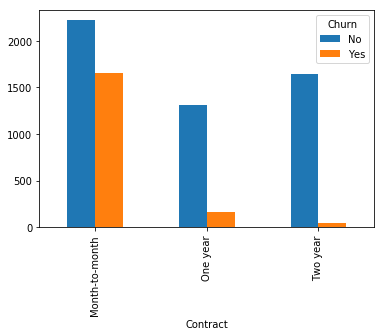

In [26]:
pd.crosstab(df["Contract"],df["Churn"]).plot(kind = "bar")
print(pd.crosstab(df["Contract"],df["Churn"]))

As expected, Contract seems to be superuseful feature. Long term contact indicates sticky customers

Churn               No   Yes
PaperlessBilling            
No                2403   469
Yes               2771  1400


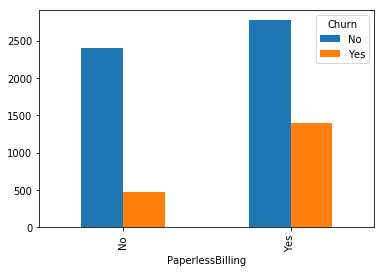

In [27]:
pd.crosstab(df["PaperlessBilling"],df["Churn"]).plot(kind = "bar")
print(pd.crosstab(df["PaperlessBilling"],df["Churn"]))

Cusotmers who have not opted for paperless billing demonstrating less churn. Logically, paperless billing should not be very 
decisive feature, this might be because Senior Citizens or long tenure customers not willing to move to paperless billing. Let's check our analysis.


In [28]:
pd.crosstab(df["SeniorCitizen"],df["PaperlessBilling"])

PaperlessBilling,No,Yes
SeniorCitizen,,
0,2606,3295
1,266,876


In [29]:
df.groupby("PaperlessBilling").tenure.mean()

PaperlessBilling
No     32.189067
Yes    32.496524
Name: tenure, dtype: float64

Above results do not support our assumption, which makes PaperlessBiling important feature. Customers not opting for Paperless
billing tend to churn less

Churn                        No   Yes
PaymentMethod                        
Bank transfer (automatic)  1286   258
Credit card (automatic)    1290   232
Electronic check           1294  1071
Mailed check               1304   308


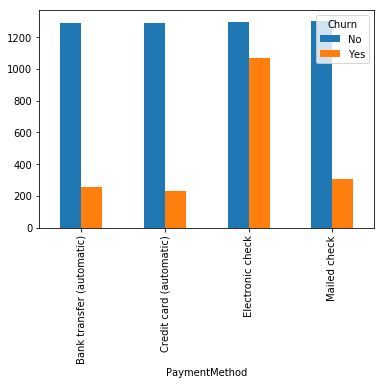

In [30]:
pd.crosstab(df["PaymentMethod"],df["Churn"]).plot(kind = "bar")
print(pd.crosstab(df["PaymentMethod"],df["Churn"]))

Electronic check seems to be an indicator of Churn, over 45% of customers opted for Electronic check have churned. As expected, those opting for automatic payment methods stay longer with the Teloco. Mailed Check payment method also exhibit lower churn. My guess is again that most of these should be senior citizens. Let's check this for fun :)

In [31]:
pd.crosstab(df["SeniorCitizen"],df["PaymentMethod"])

PaymentMethod,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
SeniorCitizen,,,,
0,1311,1301,1771,1518
1,233,221,594,94


Nope! My guess proved wrong :)

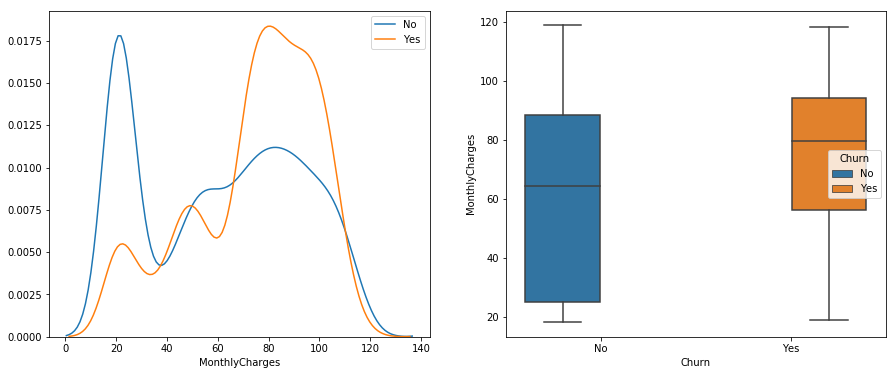

In [32]:
univariatePlot("MonthlyCharges")

In [33]:
df.groupby("Churn").MonthlyCharges.describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,61.265124,31.092648,18.25,25.10,64.425,88.4,118.75
Yes,1869.0,74.441332,24.666053,18.85,56.15,79.650,94.2,118.35


Churning customers tend to have slightly higher MonthlyCharges. Probably higher monthly charges could be the reason behind the churn

In [34]:
df.groupby("Churn").TotalCharges.describe()

,count,unique,top,freq
Churn,,,,
No,5174,4966,,11
Yes,1869,1732,20.2,6


In [35]:
df["TotalCharges"]= pd.to_numeric(df["TotalCharges"],errors='coerce')

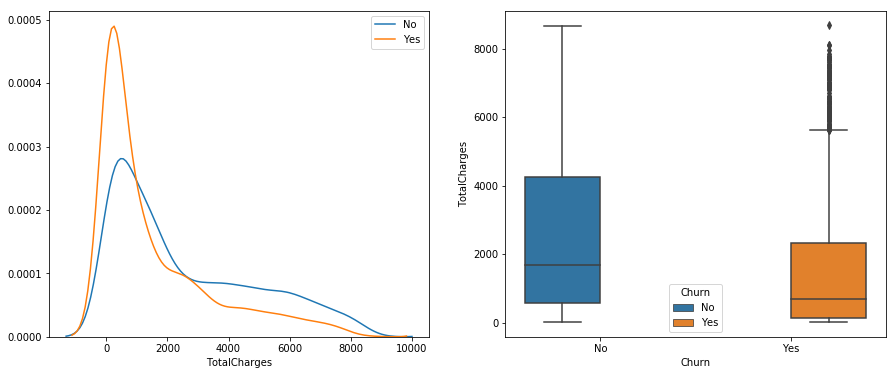

In [36]:
univariatePlot("TotalCharges")

In [37]:
df.groupby("Churn").TotalCharges.describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5163.0,2555.344141,2329.456984,18.80,577.825,1683.60,4264.125,8672.45
Yes,1869.0,1531.796094,1890.822994,18.85,134.500,703.55,2331.300,8684.80


As expected, Customers having lower Total charges tend to churn more. This can be understood better if we take into account tenure. We earlier figured out that churning customers have lower tenure. Since total charges depend on product of tenure and MonthlyCharges, churning customers will have lower Total Charges. Let's analyze the coorrelation among numerical feature so that we can avoid highly collinear features in our dataset.

In [38]:
df["tenure"].corr(df["TotalCharges"])

0.8258804609332016

In [39]:
df["MonthlyCharges"].corr(df["TotalCharges"])

0.6510648032262024

In [40]:
df["tenure"].corr(df["MonthlyCharges"])

0.2478998562861499

Thus TotalCharges are highly correlated with tenure and MonthlyCharges. Therefore it is better to avoid Total Charges from the final feature list

Okay, Let's summarize the analysis done so far. Let's classify all features in four categories Not important, important and Very important

customerID -         Not Important

gender   -           Not Important

SeniorCitizen  -     Important

Partner-             Important

Dependents-          Important

tenure-              Very Important

PhoneService-        Not Important

MultipleLines-       Not Important

InternetService-     Very Important

OnlineSecurity-      Very Important

OnlineBackup -       Important

DeviceProtection-    Important

TechSupport-         Important

StreamingTV -        Not Important      

StreamingMovies -    Not Important

Contract -           Very Important

PaperlessBilling -   Important

PaymentMethod  -     Important

MonthlyCharges -     Important

TotalCharges-        Not Important (Highly Correlated with Tenure and Monthly Charges)

# Thus, out of 20 features,7 features are not important, 9 features are important and 4 features are very important

In [41]:
feature_selection = 'imp'

if (feature_selection == 'imp'):
    x= df.loc[:,['SeniorCitizen','Partner','Dependents','tenure','InternetService','OnlineSecurity','OnlineBackup',
            'DeviceProtection','TechSupport','Contract','PaperlessBilling','PaymentMethod','MonthlyCharges']]
elif (feature_selection == 'vimp'):
    x=df.loc[:,["tenure","InternetService","OnlineSecurity","Contract"]]
elif (feature_selection == 'min'):
    x=df.loc[:,["tenure","InternetService","Contract"]]
    
    
    
y = df.loc[:,["Churn"]]
print(x.shape)
print(y.shape)

(7043, 13)
(7043, 1)


In [40]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
x['Dependents'] = lb.fit_transform(x['Dependents'])
x['Partner'] = lb.fit_transform(x['Partner'])
x['PaperlessBilling'] = lb.fit_transform(x['PaperlessBilling'])
x['OnlineBackup'] = lb.fit_transform(x['OnlineBackup'])
x['DeviceProtection'] = lb.fit_transform(x['DeviceProtection'])
x['TechSupport'] = lb.fit_transform(x['TechSupport'])
x['PaymentMethod'] = lb.fit_transform(x['PaymentMethod'])

x['InternetService'] = lb.fit_transform(x['InternetService'])
x['OnlineSecurity'] = lb.fit_transform(x['OnlineSecurity'])
x['Contract'] = lb.fit_transform(x['Contract'])

y =lb.fit_transform(y)

In [128]:
features_x = x.loc[:,['SeniorCitizen','Partner','Dependents','InternetService','OnlineSecurity','OnlineBackup',
            'DeviceProtection','TechSupport','Contract','PaperlessBilling','PaymentMethod']]
features_y = y
test = SelectKBest(score_func=chi2, k=7)
fit = test.fit(features_x, features_y)
np.set_printoptions(precision=3)
print(fit.scores_)

[ 134.352   82.412  133.036    9.821  551.612  230.087  191.303  523.304
 1115.78   105.681   58.492]


In [217]:
x.head()

,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,0,1,0,1,0,0,2,0,0,0,1,2,29.85
1,0,0,0,34,0,2,0,2,0,1,0,3,56.95
2,0,0,0,2,0,2,2,0,0,0,1,3,53.85
3,0,0,0,45,0,2,0,2,2,1,0,0,42.30
4,0,0,0,2,1,0,0,0,0,0,1,2,70.70


In [218]:
print(y)

[0 0 1 ... 0 1 0]


In [41]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 7)

In [42]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5634, 13)
(5634,)
(1409, 13)
(1409,)


In [82]:
x_train["tenure"].head()

2338    72
4705     6
3514    60
1549     1
5757    28
Name: tenure, dtype: int64

In [11]:
print(x_train["tenure"].head())
print(x_test["tenure"].head())

2338    1.613062
4705   -1.075464
3514    1.124239
1549   -1.279140
5757   -0.179289
Name: tenure, dtype: float64
6632    0.071136
3801   -0.579450
901    -0.945405
1487    0.965693
1457    0.396430
Name: tenure, dtype: float64


In [84]:
print(y_train)
print(y_test)

[0 0 0 ... 0 0 0]
[1 1 1 ... 0 0 1]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

param_leaf = [2, 3, 5]
param_estimators = [250,300,400,500]
param_split = [3,5,6,7]
param_features = [0.1,0.2]
# param_depth = [50,70,100,150,200]

# model_tree = Pipeline([
#             ('dt', DecisionTreeClassifier()),
#              ('rf', RandomForestClassifier()),
#              ('erf', ExtraTreesClassifier()),
#     ])

grid_params_en = [{ 'min_samples_leaf': param_leaf,
                    
                     'n_estimators':param_estimators,
                    'min_samples_split': param_split,
                     'max_features': param_features}]
# grid_params_dt = [{ 'min_samples_leaf': param_leaf,
#                     'max_depth': param_depth,
#                     'min_samples_split': param_split,
#                      'max_features': param_features}]

# dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
# erf = ExtraTreesClassifier()
# gs_dt = GridSearchCV(estimator=dt, param_grid = grid_params_dt, scoring = 'roc_auc',cv = 10, n_jobs = -1)
# gs_dt.fit(x_train, y_train)
gs_rf = GridSearchCV(estimator=rf, param_grid = grid_params_en, scoring = 'roc_auc',cv = 10, n_jobs = -1)
gs_rf.fit(x_train, y_train)
# gs_erf = GridSearchCV(estimator=erf, param_grid = grid_params_en, scoring = 'roc_auc',cv = 10, n_jobs = -1)
# gs_erf.fit(x_train, y_train)

# print("For Decision Tree Best parameters are ", gs_dt.best_params_,"Best score is ", gs_dt.best_score_ )
print("For Random Forest  Best parameters are ", gs_rf.best_params_,"Best score is ", gs_rf.best_score_ )
# print("For Extra Tree Best parameters are ", gs_dt.best_params_,"Best score is ", gs_dt.best_score_ )

In [15]:
print("For Random Forest  Best parameters are ", gs_rf.best_params_,"Best score is ", gs_rf.best_score_ )

For Random Forest  Best parameters are  {'max_features': 0.2, 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 500} Best score is  0.8437039517122952


In [110]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
rf = RandomForestClassifier(class_weight = 'balanced', max_features = 0.1,min_samples_leaf=3,min_samples_split = 3,n_estimators = 500)
rf.fit(x_train, y_train)
rf_predprob = rf.predict_proba(x_test)
rf_pred = rf.predict(x_test)
print("Random Forest Classfier Results with feature_selection = ", feature_selection)
print(roc_auc_score(y_test,rf_predprob[:,1]))
print("F1 = ", f1_score(y_test,rf_pred))
print("Log-loss", log_loss(y_test,rf_predprob))

Random Forest Classfier Results with feature_selection =  min
0.8190019891555682
F1 =  0.6202393906420022
Log-loss 0.5734185090603582


In [111]:
from sklearn.ensemble import ExtraTreesClassifier
erf = ExtraTreesClassifier(class_weight = 'balanced', max_features = 0.1,min_samples_leaf=3,min_samples_split = 3,n_estimators = 500)
erf.fit(x_train, y_train)
erf_predprob = erf.predict_proba(x_test)
erf_pred = erf.predict(x_test)
print("Extra Trees Classfier Results with feature_selection = ", feature_selection)
print(roc_auc_score(y_test,erf_predprob[:,1]))
print("F1 = ", f1_score(y_test,erf_pred))
print("Log-loss", log_loss(y_test,erf_predprob))

Extra Trees Classfier Results with feature_selection =  min
0.8198047194482869
F1 =  0.6163391933815926
Log-loss 0.5307982073151009


In [112]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(class_weight = 'balanced', max_features = 0.1,min_samples_leaf=3,min_samples_split = 3)
dt.fit(x_train, y_train)
dt_predprob = rf.predict_proba(x_test)
dt_pred = rf.predict(x_test)
print("Decision Tree Classfier Results with feature_selection = ", feature_selection)
print(roc_auc_score(y_test,dt_predprob[:,1]))
print("F1 = ", f1_score(y_test,dt_pred))
print("Log-loss", log_loss(y_test,dt_predprob))

Decision Tree Classfier Results with feature_selection =  min
0.8190019891555682
F1 =  0.6202393906420022
Log-loss 0.5734185090603582


In [121]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost.sklearn import XGBClassifier
depth =  [5, 6, 7, 8, 9, 10,12,15]
estimators =  [5, 10, 50, 100, 200, 500, 1000]
xg = XGBClassifier(max_depth = 500,n_estimators = 1000,verbosity=1 )
parameters = {'max_depth':15, 'n_estimators':1000}
#grid_XG_bow = GridSearchCV(XG_BOW, param_grid = parameters, scoring='roc_auc', cv=5)

#grid_XG_bow.fit(vect_train, Y_train)
#results = pd.DataFrame(grid_XG_bow.cv_results_)

xg.fit(x_train, y_train)
pred_xg = xg.predict(x_test)
print("F1 = ", f1_score(y_test,pred_xg))
# print("Best AUC Score is ",grid_XG_bow.best_score_)
# print("Optimum valus of maximum tree depth and number of base estimators are", grid_XG_bow.best_params_)


F1 =  0.5378151260504201


In [256]:
x = pd.concat([x, pd.get_dummies(x['Dependents'], prefix='Dependents')], axis=1)
x = pd.concat([x, pd.get_dummies(x['Partner'], prefix='Partner')], axis=1)

x = pd.concat([x, pd.get_dummies(x['SeniorCitizen'], prefix='SeniorCitizen')], axis=1)

x = pd.concat([x, pd.get_dummies(x['OnlineBackup'], prefix='OnlineBackup')], axis=1)
x = pd.concat([x, pd.get_dummies(x['DeviceProtection'], prefix='DeviceProtection')], axis=1)
x = pd.concat([x, pd.get_dummies(x['PaperlessBilling'], prefix='PaperlessBilling')], axis=1)
x = pd.concat([x, pd.get_dummies(x['PaymentMethod'], prefix='PaymentMethod')], axis=1)
x = pd.concat([x, pd.get_dummies(x['TechSupport'], prefix='TechSupport')], axis=1)
x = pd.concat([x, pd.get_dummies(x['Contract'], prefix='Contract')], axis=1)
x = pd.concat([x, pd.get_dummies(x['OnlineSecurity'], prefix='OnlineSecurity')], axis=1)
x = pd.concat([x, pd.get_dummies(x['InternetService'], prefix='InternetService')], axis=1)

x["tenure"] = df["tenure"]
x["MonthlyCharges"] = df["MonthlyCharges"]


In [244]:
x.head(3)

,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,...,TechSupport_2,Contract_0,Contract_1,Contract_2,OnlineSecurity_0,OnlineSecurity_1,OnlineSecurity_2,InternetService_0,InternetService_1,InternetService_2
0,0,1,0,1,0,0,2,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,0,0,0,34,0,2,0,2,0,1,...,0,0,1,0,0,0,1,1,0,0
2,0,0,0,2,0,2,2,0,0,0,...,0,1,0,0,0,0,1,1,0,0


In [257]:
if feature_selection == "imp":
    x.drop(columns = ['Dependents','Partner','InternetService','SeniorCitizen','OnlineSecurity','OnlineBackup','DeviceProtection',
                 'TechSupport','Contract','PaperlessBilling','PaymentMethod'],inplace = True)
elif feature_selection == "vimp":
     x.drop(columns = ['InternetService','OnlineSecurity'
                     ,'Contract',"MonthlyCharges"],inplace = True)

In [258]:
x.head()

,tenure,MonthlyCharges,Dependents_0,Dependents_1,Partner_0,Partner_1,SeniorCitizen_0,SeniorCitizen_1,OnlineBackup_0,OnlineBackup_1,...,TechSupport_2,Contract_0,Contract_1,Contract_2,OnlineSecurity_0,OnlineSecurity_1,OnlineSecurity_2,InternetService_0,InternetService_1,InternetService_2
0,1,29.85,1,0,0,1,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,34,56.95,1,0,1,0,1,0,1,0,...,0,0,1,0,0,0,1,1,0,0
2,2,53.85,1,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,1,0,0
3,45,42.30,1,0,1,0,1,0,1,0,...,1,0,1,0,0,0,1,1,0,0
4,2,70.70,1,0,1,0,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0


In [259]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 7)

In [260]:
from sklearn.preprocessing import StandardScaler
def scaling(data):
    data_copy= data.copy()
    if feature_selection == "imp" :
        col_names = ["tenure","MonthlyCharges"]
    elif feature_selection == "vimp" :
        col_names = ["tenure"]
    features = data_copy[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    data_copy[col_names] = features
    if feature_selection == "imp" :
        data["tenure"] = data_copy.tenure
        data["MonthlyCharges"] = data_copy.MonthlyCharges
    elif feature_selection == "vimp" :
        data["tenure"] = data_copy.tenure
    return data
x_train = scaling(x_train)
x_test = scaling(x_test)

In [261]:
print(x_train.shape)
print(x_test.shape)

(5634, 32)
(1409, 32)


In [263]:
from sklearn import linear_model
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty = 'l1',C = 10,max_iter=500,class_weight = 'balanced')
lr.fit(x_train,y_train)
lr_predprob = lr.predict_proba(x_test)
lr_pred = lr.predict(x_test)
lr_pred_train = lr.predict(x_train)
lr_predprob_train =  lr.predict_proba(x_train)
print("Test AUC", roc_auc_score(y_test,lr_predprob[:,1]))
print("Train AUC", roc_auc_score(y_train,lr_predprob_train[:,1]))
print("F1 = ", f1_score(y_test,lr_pred))
print("Log-loss", log_loss(y_test,lr_predprob))
print(classification_report(y_test,lr_pred))
print(accuracy_score(y_test,lr_pred))

Test AUC 0.8476465866292395
Train AUC 0.8415287761684117
F1 =  0.6382536382536382
Log-loss 0.48531970627301624
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1021
           1       0.53      0.79      0.64       388

    accuracy                           0.75      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.75      0.76      1409

0.7530163236337828


https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve

In [265]:
for w in [2,3,4,5]:
    print('---Weight of {} for Churned Customers---'.format(w))
    lr_model = LogisticRegression(class_weight={0:1,1:w})
    lr_model.fit(x_train,y_train)

    lr_pred_wt = lr_model.predict(x_test)
    lr_predprob_wt = lr_model.predict_proba(x_test)
    print(classification_report(y_test,lr_pred_wt))
    print("F1 = ", f1_score(y_test,lr_pred_wt))
    print("Log-loss", log_loss(y_test,lr_predprob_wt))

---Weight of 2 for Churned Customers---
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1021
           1       0.59      0.73      0.65       388

    accuracy                           0.78      1409
   macro avg       0.74      0.77      0.75      1409
weighted avg       0.80      0.78      0.79      1409

F1 =  0.6513761467889907
Log-loss 0.4466545542546281
---Weight of 3 for Churned Customers---
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1021
           1       0.53      0.80      0.64       388

    accuracy                           0.75      1409
   macro avg       0.72      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409

F1 =  0.6352459016393442
Log-loss 0.4951867203721177
---Weight of 4 for Churned Customers---
              precision    recall  f1-score   support

           0       0.92      0.66      0.77      1021
           